# Analysis by Ilan Eskinazi

First, we load our libraries for data manipulation, natural language processing, plotting

In [1]:
import pandas as pd
import seaborn as sb
import nltk
from nltk import tokenize
import gensim
from sklearn.metrics import mean_squared_error
import numpy as np

Location of pretrained word2vec model: (can download from: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)

In [2]:
pathToGoogleVec = '/home/ilan/googleVec/GoogleNews-vectors-negative300.bin'

Let's read in the data:

In [3]:
originalDF = pd.read_csv('./data/dataset.txt',delimiter=',',header=None)

Let's take a look at the first few rows:

In [4]:
originalDF.head(5)

0      1   2  \
0  product2057970.html  17.48   3   
1  product1996870.html  10.10   3   
2  product2407695.html  12.38   0   
3  product1797873.html  15.22   5   
4  product1066238.html   4.28  60   

                                                   3  \
0  Trendy Women's Shoulder Bag With Metal and Che...   
1  Causal Women's Athletic Shoes With Splicing an...   
2  Casual Style Elastic Waist Printed Loose-Fitti...   
3  Sweet Women's Shoulder Bag With PU Leather and...   
4  Stylish Elastic Waist Solid Color Faux Leather...   

                                                   4  
0  http://gloimg.sammydress.com/S/2015/201509/thu...  
1                                                NaN  
2  http://gloimg.sammydress.com/S/2015/201512/thu...  
3  http://gloimg.sammydress.com/S/2015/201507/thu...  
4  http://gloimg.sammydress.com/S/2014/201402/thu...

Let's rename the columns:

In [5]:
DFrenamed = originalDF.rename(columns={0:'Product',1:'Cost',2:'Score',3:'Description',4:'url'})
DFrenamed.head(10)

Product   Cost  Score  \
0  product2057970.html  17.48      3   
1  product1996870.html  10.10      3   
2  product2407695.html  12.38      0   
3  product1797873.html  15.22      5   
4  product1066238.html   4.28     60   
5  product1007291.html   0.00      0   
6  product1967710.html  10.69      2   
7  product2024394.html   6.85      0   
8  product2445481.html  11.50      0   
9  product1846783.html   7.20      2   

                                         Description  \
0  Trendy Women's Shoulder Bag With Metal and Che...   
1  Causal Women's Athletic Shoes With Splicing an...   
2  Casual Style Elastic Waist Printed Loose-Fitti...   
3  Sweet Women's Shoulder Bag With PU Leather and...   
4  Stylish Elastic Waist Solid Color Faux Leather...   
5                                                NaN   
6  Stylish V-Neck Long Sleeve Color Block Loose-F...   
7  Pair of Stylish Lace and Bow Embellished Solid...   
8  Sexy Stand Collar Long Sleeve Sequined Dress F...   
9  Sexy Women's Round Neck Black Hollow Out PU Le...   

                                                 url  
0  http://gloimg.sammydress.com/S/2015/201509/thu...  
1                                                NaN  
2  http://gloimg.sammydress.com/S/2015/201512/thu...  
3  http://gloimg.sammydress.com/S/2015/201507/thu...  
4  http://gloimg.sammydress.com/S/2014/201402/thu...  
5                                                NaN  
6                                                NaN  
7                                                NaN  
8  http://gloimg.sammydress.com/S/pdm-product-pic...  
9                                                NaN

Now, we can take a closer look at the data

In [6]:
DFrenamed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9974 entries, 0 to 9973
Data columns (total 5 columns):
Product        9974 non-null object
Cost           9974 non-null float64
Score          9974 non-null int64
Description    9906 non-null object
url            6905 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 389.7+ KB


Let's clean up the data a little bit. If the cost is zero, let's remove the row.

In [7]:
DF1=DFrenamed[DFrenamed['Cost'] != 0 | DFrenamed['Description'].str.contains('NaN')]
DF1.head(10)

Product   Cost  Score  \
0   product2057970.html  17.48      3   
1   product1996870.html  10.10      3   
2   product2407695.html  12.38      0   
3   product1797873.html  15.22      5   
4   product1066238.html   4.28     60   
6   product1967710.html  10.69      2   
7   product2024394.html   6.85      0   
8   product2445481.html  11.50      0   
9   product1846783.html   7.20      2   
10  product1914642.html  12.39      8   

                                          Description  \
0   Trendy Women's Shoulder Bag With Metal and Che...   
1   Causal Women's Athletic Shoes With Splicing an...   
2   Casual Style Elastic Waist Printed Loose-Fitti...   
3   Sweet Women's Shoulder Bag With PU Leather and...   
4   Stylish Elastic Waist Solid Color Faux Leather...   
6   Stylish V-Neck Long Sleeve Color Block Loose-F...   
7   Pair of Stylish Lace and Bow Embellished Solid...   
8   Sexy Stand Collar Long Sleeve Sequined Dress F...   
9   Sexy Women's Round Neck Black Hollow Out PU Le...   
10  Solid Color Loose-Fitting Stylish Turn-Down Co...   

                                                  url  
0   http://gloimg.sammydress.com/S/2015/201509/thu...  
1                                                 NaN  
2   http://gloimg.sammydress.com/S/2015/201512/thu...  
3   http://gloimg.sammydress.com/S/2015/201507/thu...  
4   http://gloimg.sammydress.com/S/2014/201402/thu...  
6                                                 NaN  
7                                                 NaN  
8   http://gloimg.sammydress.com/S/pdm-product-pic...  
9                                                 NaN  
10  http://gloimg.sammydress.com/S/pdm-product-pic...

## The next step will be to categorize the items from the given description

Creating tokens from item descriptions

In [8]:
DF2 = pd.DataFrame(DF1.drop(['url'],axis=1))
DF2['Tokenized'] = DF2['Description'].apply(lambda row: nltk.word_tokenize(row.lower()))

In [9]:
DF2.head(10)

Product   Cost  Score  \
0   product2057970.html  17.48      3   
1   product1996870.html  10.10      3   
2   product2407695.html  12.38      0   
3   product1797873.html  15.22      5   
4   product1066238.html   4.28     60   
6   product1967710.html  10.69      2   
7   product2024394.html   6.85      0   
8   product2445481.html  11.50      0   
9   product1846783.html   7.20      2   
10  product1914642.html  12.39      8   

                                          Description  \
0   Trendy Women's Shoulder Bag With Metal and Che...   
1   Causal Women's Athletic Shoes With Splicing an...   
2   Casual Style Elastic Waist Printed Loose-Fitti...   
3   Sweet Women's Shoulder Bag With PU Leather and...   
4   Stylish Elastic Waist Solid Color Faux Leather...   
6   Stylish V-Neck Long Sleeve Color Block Loose-F...   
7   Pair of Stylish Lace and Bow Embellished Solid...   
8   Sexy Stand Collar Long Sleeve Sequined Dress F...   
9   Sexy Women's Round Neck Black Hollow Out PU Le...   
10  Solid Color Loose-Fitting Stylish Turn-Down Co...   

                                            Tokenized  
0   [trendy, women, 's, shoulder, bag, with, metal...  
1   [causal, women, 's, athletic, shoes, with, spl...  
2   [casual, style, elastic, waist, printed, loose...  
3   [sweet, women, 's, shoulder, bag, with, pu, le...  
4   [stylish, elastic, waist, solid, color, faux, ...  
6   [stylish, v-neck, long, sleeve, color, block, ...  
7   [pair, of, stylish, lace, and, bow, embellishe...  
8   [sexy, stand, collar, long, sleeve, sequined, ...  
9   [sexy, women, 's, round, neck, black, hollow, ...  
10  [solid, color, loose-fitting, stylish, turn-do...

Let's take a look at the first token:

In [10]:
DF2.Tokenized.iloc[0]

['trendy',
 'women',
 "'s",
 'shoulder',
 'bag',
 'with',
 'metal',
 'and',
 'checked',
 'design']

We can see that we have a list of words, including apostrophes, conjuctions, and prepositions to remove later

In [11]:
DF2.head()

Product   Cost  Score  \
0  product2057970.html  17.48      3   
1  product1996870.html  10.10      3   
2  product2407695.html  12.38      0   
3  product1797873.html  15.22      5   
4  product1066238.html   4.28     60   

                                         Description  \
0  Trendy Women's Shoulder Bag With Metal and Che...   
1  Causal Women's Athletic Shoes With Splicing an...   
2  Casual Style Elastic Waist Printed Loose-Fitti...   
3  Sweet Women's Shoulder Bag With PU Leather and...   
4  Stylish Elastic Waist Solid Color Faux Leather...   

                                           Tokenized  
0  [trendy, women, 's, shoulder, bag, with, metal...  
1  [causal, women, 's, athletic, shoes, with, spl...  
2  [casual, style, elastic, waist, printed, loose...  
3  [sweet, women, 's, shoulder, bag, with, pu, le...  
4  [stylish, elastic, waist, solid, color, faux, ...

## Creating categories

Loading Google's pre-trained word2vec model pretrained with billions of words

In [12]:
model = gensim.models.KeyedVectors.load_word2vec_format(pathToGoogleVec, binary=True)

Now, let's make small dictionaries that define what is each category

In [13]:
shirt_cat = ['shirt','blouse','polo','turtleneck','top','t-shirt']
jacket_cat = ['jacket','coat','blazer','cape']
pants_cat = ['pants','trousers','chinos','jeans','denims','corduroys','leggings']
purse_cat = ['purse','bag','handbag']
sweater_cat = ['sweater','cardigan','hoodie']
shoes_cat = ['shoe','boot','sneaker','pump','sandal','shoes','boots','sneakers','pumps','sandals']
accesories_cat = ['gloves','belt','pashmina','scarf','knitwear']
jewelry_cat = ['necklace','chain','earrings']
hats_cat = ['hat','beret','beanie']
dress_cat = ['dress']
bathing_cat = ['swimsuit','bathing','swimming','bikini','swimwear']
bodysuit_cat = ['bodysuit','jumpsuit','playsuit']
skirt_cat = ['skirt','miniskirt']
underwear_cat = ['underwear','panties','bra','socks','stockings']
shorts_cat = ['shorts']

In [14]:
cat_dict = [shirt_cat,jacket_cat,pants_cat,purse_cat,sweater_cat,shoes_cat,accesories_cat,jewelry_cat,hats_cat,dress_cat,bathing_cat,bodysuit_cat,skirt_cat,underwear_cat,shorts_cat]
catRef = {0:'shirt',1:'jacket',2:'pants',3:'purse',4:'sweater',5:'shoes',6:'accesories',7:'jewelry',8:'hats',9:'dress',10:'swimwear',11:'bodysuit',12:'skirt',13:'underwear',14:'shorts'}

In [15]:
cat_dict
catRef

{0: 'shirt',
 1: 'jacket',
 2: 'pants',
 3: 'purse',
 4: 'sweater',
 5: 'shoes',
 6: 'accesories',
 7: 'jewelry',
 8: 'hats',
 9: 'dress',
 10: 'swimwear',
 11: 'bodysuit',
 12: 'skirt',
 13: 'underwear',
 14: 'shorts'}

Store a vector representations of this list of lists using the word2vec model

In [16]:
cat_vec = [] # main list
for cat in cat_dict:
    itemsList = [] # internal list
    for item in cat:
        try:
            vec = model[item] # get vector for word
            itemsList.append(vec) 
        except KeyError: # if word not in vocabulary, ignore it
            continue
    cat_vec.append(itemsList)

Later, for each item in filtered and tokenized description in the dataframe, we will find the nearest vectorized word in our categories list. This way we will categorize the row according to semantic similarity.

But first let's create a naive categorization function that quickly checks if any of the tokens are in the "dictionary"

In [17]:
def naiveCategorize(row):  
    tempList = []
    myCatList = []
    for word in row:
        # going through all possible pre-defined words
        for ind, catList in enumerate(cat_dict):
            if word in catList:
                myCatList.append(catRef[ind])
        
    return myCatList

In [18]:
DF2['NaiveCategories'] = DF2['Tokenized'].apply(lambda row: naiveCategorize(row))

In [19]:
DF2.head(40)

Product   Cost  Score  \
0   product2057970.html  17.48      3   
1   product1996870.html  10.10      3   
2   product2407695.html  12.38      0   
3   product1797873.html  15.22      5   
4   product1066238.html   4.28     60   
6   product1967710.html  10.69      2   
7   product2024394.html   6.85      0   
8   product2445481.html  11.50      0   
9   product1846783.html   7.20      2   
10  product1914642.html  12.39      8   
11  product2319598.html   7.52      0   
12  product2173774.html  21.30      4   
13  product2375559.html  13.53      3   
14  product2243530.html  29.92      0   
15  product1470075.html   5.39      3   
16   product779584.html   9.86      5   
17  product2086352.html   8.72      1   
18  product2047577.html  11.70      5   
19  product2384777.html  15.60      0   
20  product2277372.html   9.85      1   
21  product1951781.html   5.70      1   
22  product2050298.html  16.14      0   
23  product2405608.html   6.34      0   
24  product2359070.html  13.18      0   
25  product1368114.html  13.12      1   
26  product2364145.html  15.14      0   
27  product2038472.html   7.54      6   
28  product2085232.html  10.32      1   
29  product1110345.html   9.14      8   
30  product2031322.html   9.85      0   
31  product2447039.html   8.05      0   
32  product1708183.html   7.79      3   
33  product2315229.html  10.09      0   
34  product2133230.html  11.84      7   
35  product1649642.html   8.55      5   
36  product2192737.html   8.47      0   
37  product2278952.html   3.83      1   
38  product1855265.html   9.94      5   
39  product2445203.html   6.85      1   
40  product2455156.html  36.93      0   

                                          Description  \
0   Trendy Women's Shoulder Bag With Metal and Che...   
1   Causal Women's Athletic Shoes With Splicing an...   
2   Casual Style Elastic Waist Printed Loose-Fitti...   
3   Sweet Women's Shoulder Bag With PU Leather and...   
4   Stylish Elastic Waist Solid Color Faux Leather...   
6   Stylish V-Neck Long Sleeve Color Block Loose-F...   
7   Pair of Stylish Lace and Bow Embellished Solid...   
8   Sexy Stand Collar Long Sleeve Sequined Dress F...   
9   Sexy Women's Round Neck Black Hollow Out PU Le...   
10  Solid Color Loose-Fitting Stylish Turn-Down Co...   
11  Fashion Christmas Candy Color Deer Horn Beret ...   
12     Women's Plunging Neck Pure Color Chiffon Dress   
13  Sexy Solid Color Turtleneck Crop Top and High ...   
14  Stylish Hooded Long Sleeve Color Spliced Women...   
15  Stylish Alloy Leaf Decorated Solid Color Elast...   
16  Popular Lapel Leopard Print Long Sleeve Blazer...   
17  Stylish Pure White Woolen Yarn Knitted Bucket ...   
18  Active Color Block Letter Bodycon Sport Leggin...   
19  Sweet Scoop Neck Halter Hollow Out Women's Bik...   
20  Sexy Women's Plunging Neck White Long Sleeve T...   
21  Fashion Letters Shape Embroidery Solid Color K...   
22  Chic Long Sleeve Turn-Down Collar Double-Breas...   
23  Trendy Women's Crossbody Bag With Plaid and Ca...   
24  Simple Women's Short Boots With Zipper and Fri...   
25  Long Sleeves Solid Color Pockets Stylish Long ...   
26  Ladylike Women's Hooded Snowflake Pattern Thic...   
27  Sexy Spaghetti Strap Solid Color Knitted Crop ...   
28   Chic Hooded Long Sleeve Printed Hoodie For Women   
29  Stylish Women's Scoop Neck Batwing Sleeve Prin...   
30  Stylish V-Neck Long Sleeve Slimming Sweater Fo...   
31  Stylish Various Flowers Jacquard Ethnic Tassel...   
32  Casual Scoop Neck Sequined Striped Anchor Tank...   
33  Sexy Turtle Neck Sleeveless See-Through Cut Ou...   
34  Trendy Women's Crossbody Bag With Fringe and W...   
35  Fashionable Strapless Openwork Floral Pattern ...   
36  Chic Round Neck Long Sleeve Printed Loose-Fitt...   
37  Pair of Stylish Bow and Tassel Pendant Embelli...   
38  Fashionable Self-Tie Solid Color A-Line Skirt ...   
39  Chic Round Neck Long Sleeve Pure Color Bodycon...   
40  Trendy Women's Flat Shoes With Elastic and Seq... 

Using NLTK, let's remove anything that is not tagged as NN for common noun, or NNS for common noun in plural

In [20]:
nltk.pos_tag(DF2.Tokenized.iloc[0])

[('trendy', 'JJ'),
 ('women', 'NNS'),
 ("'s", 'POS'),
 ('shoulder', 'NN'),
 ('bag', 'NN'),
 ('with', 'IN'),
 ('metal', 'NN'),
 ('and', 'CC'),
 ('checked', 'VBD'),
 ('design', 'NN')]

In [21]:
def filterTokens(row, acceptableList = ['NN','NNS']): # ,'VB','VBD','JJ' verbs and adjectives
    newList = []
    tagged = nltk.pos_tag(row)
    for taggedItem in tagged:
        if taggedItem[1] in acceptableList and taggedItem[0] != 'women':
            newList.append(taggedItem[0])
    return newList

In [22]:
DF2['FilteredTokens'] = DF2['Tokenized'].apply(lambda row: filterTokens(row))

In [23]:
DF2.FilteredTokens.iloc[0]

['shoulder', 'bag', 'metal', 'design']

The following categorize() function finds the word in the dictionary with a vector representation that most closely approaches any of the filtered tokens' vector representations. It outputs a tuple of the category and the key word that used to classify the category.

In [24]:
def categorize(row):    
    tempList = []
    tempListWords = []
    for word in row:
        try:
            vec = model[word]
            tempList.append(vec)
            tempListWords.append(word)
        except KeyError: # if word not in vocabulary, ignore it
            continue

    minimumVal = 10000 # minimum value (large initialization)
    myKeyWord = ''
    myCat = -1 # category    
    for indTokens,vec in enumerate(tempList):
        # going through all possible wordvec definitions
        for indCat,catList in enumerate(cat_vec):
            for dicVec in catList:
                value = np.sqrt(mean_squared_error(vec, dicVec))
                # print(value)
                if value < minimumVal:
                    minimumVal = value
                    myKeyWord = tempListWords[indTokens]
                    myCat = catRef[indCat]
    return (myCat, myKeyWord)

In [25]:
DF2['Categories'] = DF2.apply(lambda row: categorize(row['FilteredTokens']) if row['NaiveCategories'] in ([],) else np.nan, axis=1)

In [26]:
pd.set_option('display.max_colwidth', -1)
DF2[['Description','FilteredTokens','Categories']].dropna().head(100)

Description  \
36   Chic Round Neck Long Sleeve Printed Loose-Fitting Sweatshirt For Women                  
56   Solid Color Lace-Up Stylish V-Neck 3/4 Sleeve Jumpsuits For Women                       
58   Chic Women's Elastic Waist Black Plus Size Culotte                                      
61   Stylish High-Waisted Turn-Up Design Denim Short For Women                               
64   Stylish Smooth Wrinkles Knitted Newsboy Cap For Women                                   
80   Stylish Collarless 3/4 Sleeve Loose-Fitting Openwork Solid Color Kimono For Women       
94   Sexy Women's Lapel Solid Color 3/4 Sleeve Romper                                        
100  Casual Round Neck Long Sleeve Printed Emoji Sweatshirt For Women                        
110  Stylish Cowl Neck Long Sleeve Solid Color Asymmetrical Sweatshirt For Women             
122  Fashion Style Women's Satchel With String and Splicing Design                           
175  Stylish Jewel Neck Long Sleeve Dolphin Pattern Sweatshirt For Women                     
177  Alluring Women's Slimming Corset                                                        
180  Stylish Letter Embroidery Handpainted Circle Pattern Baseball Cap For Women             
187  Casual Thick Scoop Neck Star Printed Long Pullover Sweatshirt For Women                 
190  Vintage Strapless Lace-Up Slimming Corset For Women                                     
205  Fashionable Half Sun Embroidery Baseball Cap For Men and Women                          
207  Simple Women's Slippers With Flip-Flop and Wedge Design                                 
212  Brief Women's Round Neck Keys Embroidery Long Sleeve Sweatshirt                         
233  Long Sleeves Embroidered Stylish Lace Capelet For Women                                 
238  Stylish Alloy Buckle and Solid Color Design Elastic Waistband For Women                 
255  Stylish Hollow Out Vintage Totem Alloy Embellished Elastic Waistband For Women          
262  Trendy Women's Satchel With Zipper and Solid Colour Design                              
271  Stylish Bowknot Embellished Color Matching Waistband For Women                          
283  Stylish Plunging Neck 3/4 Sleeve Lace Embellished Romper For Women                      
286  Stylish Cowl Neck Long Sleeve Printed Spliced Button Embellished Sweatshirt For Women   
289  Sexy Scoop Collar Short Sleeve Flag Print Cover Up For Women                            
318  Stylish Letter Embroidery Houndstooth Pattern Baseball Cap For Women                    
340  Cute Round Collar Long Sleeve Cartoon Pattern Loungewear Suit For Women                 
341  Stylish Double-Deck Bow Embellished Elastic Waistband For Women                         
345  Simple Women's Striped Overalls                                                         
..                               ...                                                         
622  Graceful Women's Floral Print Skinny Corset                                             
625  Stylish Women's Satchel With Canvas and Colour Block Design                             
626  Stylish Jewel Neck Long Sleeve Plaid Spliced Women's Sweatshirt                         
631  Stylish Turn-Down Collar Skew Zipper Fuzzy Women's Waistcoat                            
645  Retro Women's Satchel With Solid Color and Zippers Design                               
647  Preppy Style Cartoon Print White Long Sleeve Pullover Sweatshirt For Women              
650  Stylish Various Cute Decoration Design Knitted Neck Warmer For Women                    
657  Preppy Women's Satchel With Tassel and Rivet Design                                     
665  Fashionable Scoop Neck Long Sleeve Knitted Splicing Women's Sweatshirt                  
709  Stylish Big Rose Embellished Solid Color Elastic Waistband For Women                    
710  Sexy V-Neck Sleeveless See-Through Solid Color Cover-Up For Women                       
712  Stylish Round Collar Long Sleeve

Inspect categorizations

In [27]:
DF2[['FilteredTokens','Categories']][DF2['Categories'].notnull()]

FilteredTokens  \
36    [round, neck, sweatshirt]                                   
56    [color, v-neck, sleeve, jumpsuits]                          
58    [waist, size, culotte]                                      
61    [design, denim]                                             
64    [smooth, wrinkles, cap]                                     
80    [collarless, openwork, color, kimono]                       
94    [lapel, color, sleeve, romper]                              
100   [round, neck, emoji, sweatshirt]                            
110   [cowl, neck, color, sweatshirt]                             
122   [fashion, style, satchel, string, design]                   
175   [jewel, neck, pattern, sweatshirt]                          
177   [slimming, corset]                                          
180   [letter, embroidery, circle, pattern, baseball, cap]        
187   [thick, scoop, neck, star, sweatshirt]                      
190   [vintage, slimming, corset]                                 
205   [half, embroidery, baseball, cap, men]                      
207   [slippers, wedge, design]                                   
212   [round, neck, keys, sweatshirt]                             
233   [sleeves, lace, capelet]                                    
238   [alloy, buckle, color, design, waistband]                   
255   [hollow, vintage, totem, alloy, waistband]                  
262   [satchel, zipper, colour, design]                           
271   [bowknot, color, matching, waistband]                       
283   [plunging, neck, sleeve, lace, romper]                      
286   [cowl, neck, button, sweatshirt]                            
289   [scoop, collar, sleeve, flag, print]                        
318   [letter, embroidery, houndstooth, baseball, cap]            
340   [cute, round, collar, cartoon, pattern, suit]               
341   [double-deck, bow, waistband]                               
345   [overalls]                                                  
...          ...                                                  
9702  [v-neck, color, cover-up]                                   
9707  [pu, tartan, pattern, baseball, cap]                        
9710  [color, tassel, waist, rope]                                
9716  [round, neck, letter, pattern, sweatshirt]                  
9725  [lace, body, corset]                                        
9730  [sexy, round, neck, see-through, hollow, cover-up]          
9742  [simple, color, downy, chunky, neck, warmer]                
9744  [scoop, neck, sleeve, color, suit]                          
9755  [hemp, flowers, downy, earmuff]                             
9762  [color, sweatshirt]                                         
9772  [flower, tassel, waist, rope]                               
9775  [style, satchel, nylon, design]                             
9784  [sexy, neck, sleeve]                                        
9800  [satchel, zipper, people, design]                           
9805  [style, round, collar, letter, pattern, size, sweatshirt]   
9841  [letter, embroidery, baseball, cap]                         
9843  [sleeve, pattern, sweatshirt]                               
9850  [embroidery, bow, headband]                                 
9863  [color, rabbit, hair, design, cap]                          
9864  [star, shape, downy, earmuff]                               
9872  [stripe, print, splice, neck, warmer]                       
9875  [style, polka, print, ruffles, swimsuits]                   
9877  [star, shape, downy, earmuff]                               
9889  [polka, dot, pattern, briefs]                               
9900  [spaghetti, romper]                                         
9906  [pair, step, pu, leg, warmers]                              
9930  [round, neck, deerlet, print, sweatshirt]                   
9933  [sexy, neck, see-through, color, romper]                    
9952  [v, neck, letter, print

While the algorithm correctly identifies sweatshirt (line 36) as a sweater, satchel as a purse (line 122), and romper as a bodysuit (line 94) it also classified corset as a skirt (line 190), and found the word "half" to be more similar to "shirt" than "cap" to any word in our dictionary (line 205).

Finish categorizing, and if multiple categories found, create new category called "combination"

In [28]:
DF2.head()

Product   Cost  Score  \
0  product2057970.html  17.48  3       
1  product1996870.html  10.10  3       
2  product2407695.html  12.38  0       
3  product1797873.html  15.22  5       
4  product1066238.html  4.28   60      

                                                                Description  \
0  Trendy Women's Shoulder Bag With Metal and Checked Design                  
1  Causal Women's Athletic Shoes With Splicing and Striped Design             
2  Casual Style Elastic Waist Printed Loose-Fitting Ankle Pants For Women     
3  Sweet Women's Shoulder Bag With PU Leather and Solid Color Design          
4  Stylish Elastic Waist Solid Color Faux Leather Skinny Leggings For Women   

                                                                              Tokenized  \
0  [trendy, women, 's, shoulder, bag, with, metal, and, checked, design]                  
1  [causal, women, 's, athletic, shoes, with, splicing, and, striped, design]             
2  [casual, style, elastic, waist, printed, loose-fitting, ankle, pants, for, women]      
3  [sweet, women, 's, shoulder, bag, with, pu, leather, and, solid, color, design]        
4  [stylish, elastic, waist, solid, color, faux, leather, skinny, leggings, for, women]   

  NaiveCategories                               FilteredTokens Categories  
0  [purse]         [shoulder, bag, metal, design]               NaN        
1  [shoes]         [shoes, splicing, design]                    NaN        
2  [pants]         [style, waist, pants]                        NaN        
3  [purse]         [shoulder, bag, pu, leather, color, design]  NaN        
4  [pants]         [waist, color, faux, leather, leggings]      NaN

In [29]:
def checkEqual(iterator):
   return len(set(iterator)) <= 1

def mergeCategories(row):
    if len(row['NaiveCategories']) == 1:
        return row['NaiveCategories'][0]
    # if multiple words identified
    elif len(row['NaiveCategories']) > 1:
        # if they are the same (e.g., swimming and bikini)
        if checkEqual(row['NaiveCategories']):
            return row['NaiveCategories'][0]
        else:
            # and if they are different return a new category
            return 'combination'
    elif len(row['NaiveCategories']) == 0:
        return row['Categories'][0]

In [30]:
DF3 = pd.DataFrame(DF2)
DF3['FinalCategory'] = DF3.apply(lambda row: mergeCategories(row), axis=1)

In [31]:
DF3.head(100)

Product   Cost  Score  \
0    product2057970.html  17.48  3       
1    product1996870.html  10.10  3       
2    product2407695.html  12.38  0       
3    product1797873.html  15.22  5       
4    product1066238.html  4.28   60      
6    product1967710.html  10.69  2       
7    product2024394.html  6.85   0       
8    product2445481.html  11.50  0       
9    product1846783.html  7.20   2       
10   product1914642.html  12.39  8       
11   product2319598.html  7.52   0       
12   product2173774.html  21.30  4       
13   product2375559.html  13.53  3       
14   product2243530.html  29.92  0       
15   product1470075.html  5.39   3       
16   product779584.html   9.86   5       
17   product2086352.html  8.72   1       
18   product2047577.html  11.70  5       
19   product2384777.html  15.60  0       
20   product2277372.html  9.85   1       
21   product1951781.html  5.70   1       
22   product2050298.html  16.14  0       
23   product2405608.html  6.34   0       
24   product2359070.html  13.18  0       
25   product1368114.html  13.12  1       
26   product2364145.html  15.14  0       
27   product2038472.html  7.54   6       
28   product2085232.html  10.32  1       
29   product1110345.html  9.14   8       
30   product2031322.html  9.85   0       
..                   ...   ...  ..       
72   product268915.html   4.86   1       
73   product2388841.html  32.83  0       
74   product2460593.html  36.56  0       
75   product2040292.html  7.49   39      
76   product2446804.html  35.58  0       
77   product2025276.html  6.83   6       
78   product1723422.html  20.18  0       
79   product2036128.html  7.49   2       
80   product2443957.html  10.93  0       
81   product2178608.html  10.90  7       
82   product2233368.html  6.50   3       
83   product1752492.html  9.45   1       
84   product2448694.html  6.80   0       
85   product2005600.html  13.54  3       
86   product1740228.html  11.37  2       
88   product1961491.html  6.45   23      
89   product2141863.html  16.25  0       
90   product2334258.html  12.16  0       
91   product1503052.html  11.25  5       
92   product1943863.html  8.96   5       
93   product1369165.html  14.30  6       
94   product2277380.html  13.78  0       
95   product2198826.html  9.45   0       
96   product2408281.html  24.05  0       
97   product2393881.html  31.05  0       
98   product2041577.html  8.15   2       
99   product1642041.html  9.69   2       
100  product2302635.html  8.96   0       
101  product2184152.html  11.66  1       
102  product2408067.html  5.46   0       

                                                                             Description  \
0    Trendy Women's Shoulder Bag With Metal and Checked Design                             
1    Causal Women's Athletic Shoes With Splicing and Striped Design                        
2    Casual Style Elastic Waist Printed Loose-Fitting Ankle Pants For Women                
3    Sweet Women's Shoulder Bag With PU Leather and Solid Color Design                     
4    Stylish Elastic Waist Solid Color Faux Leather Skinny Leggings For Women              
6    Stylish V-Neck Long Sleeve Color Block Loose-Fitting T-Shirt For Women                
7    Pair of Stylish Lace and Bow Embellished Solid Color Gloves For Women                 
8    Sexy Stand Collar Long Sleeve Sequined Dress For Women                                
9    Sexy Women's Round Neck Black Hollow Out PU Leather Splicing Crop Top                 
10   Solid Color Loose-Fitting Stylish Turn-Down Collar Long Sleeve Dress For Women        
11   Fashion Christmas Candy Color Deer Horn Beret For Women                               
12   Women's Plunging Neck Pure Color Chiffon Dress                                        
13   Sexy Solid Color Turtleneck Crop Top and High Waist Bodycon Pants Twinset For Women   
14   Stylish Hooded Long Sleeve Color Spliced Women's Thicken Coat                         
15   Stylish Alloy Leaf Decorate

Remove rows that we were unable to categorize (only 1)

In [32]:
DF3 = DF3[DF3['FinalCategory'] != -1]

Save dataframe to file

In [33]:
DF3.to_csv('categorizedProducts.csv',columns=['Product','Cost','Score','FinalCategory'])

## Creating a model of the best products
### As with any model, we have to make some assumptions:
1) Our category classifications are correct

2) There are diminishing returns for review scores beyond a certain score, (e.g., beyond 30)

3) The "goodness" of a product can be attributed, in part, to a linear function of the cost

Calculating the first quantile for cost per category

In [34]:
costQ1 = DF3[['Cost','FinalCategory']].groupby(by='FinalCategory',axis=0).quantile(.25)

Calculating the third quantile for cost per category

In [35]:
costQ3 = DF3[['Cost','FinalCategory']].groupby(by='FinalCategory',axis=0).quantile(.75)

### This is the mathematical model that assigns a value to each product

In [36]:
def scoring(row,c):
    cost = row['Cost']
    score = row['Score']
    q1 = costQ1.loc[row['FinalCategory']]['Cost']
    q3 = costQ3.loc[row['FinalCategory']]['Cost']
    # For the cost model yc: yc = -1/(x2-x1)*(cost-x2) where x2 is the third quantile and x1 is the 1st quantile
    yc = -1/(q3-q1)*(cost-q3)
    # For the score model ys: ys = tanh(1/c*x) where c is the "point of diminishing returns", and x is the score
    ys = np.tanh(1/c*score)
    valueGiven = yc + ys
    return valueGiven

In [37]:
DF4 = pd.DataFrame(DF3)
DF4['valueGiven'] = DF3.apply(lambda x: scoring(x,30), axis =1)

In [38]:
DF4.head(3)

Product   Cost  Score  \
0  product2057970.html  17.48  3       
1  product1996870.html  10.10  3       
2  product2407695.html  12.38  0       

                                                              Description  \
0  Trendy Women's Shoulder Bag With Metal and Checked Design                
1  Causal Women's Athletic Shoes With Splicing and Striped Design           
2  Casual Style Elastic Waist Printed Loose-Fitting Ankle Pants For Women   

                                                                           Tokenized  \
0  [trendy, women, 's, shoulder, bag, with, metal, and, checked, design]               
1  [causal, women, 's, athletic, shoes, with, splicing, and, striped, design]          
2  [casual, style, elastic, waist, printed, loose-fitting, ankle, pants, for, women]   

  NaiveCategories                  FilteredTokens Categories FinalCategory  \
0  [purse]         [shoulder, bag, metal, design]  NaN        purse          
1  [shoes]         [shoes, splicing, design]       NaN        shoes          
2  [pants]         [style, waist, pants]           NaN        pants          

   valueGiven  
0 -0.077152    
1  1.323121    
2  0.193548

Now let's display the top 2 products of each category:

In [39]:
dfList = []
for name, group in DF4.groupby('FinalCategory'):
    dfList.append(group)

In [40]:
for ind,df in enumerate(dfList):
    a = df[['Product','Cost','Score','Description','FinalCategory','valueGiven']].nlargest(2,'valueGiven').head()
    if ind == 0:
        bestDF = pd.DataFrame(a)
    else:
        bestDF = pd.concat([bestDF,a])

## The 2 best products by category

In [41]:
bestDF

Product  Cost  Score  \
7031  product1177188.html  2.90  62      
9163  product1194959.html  3.38  40      
6360  product2166554.html  4.46  3       
1834  product1874315.html  8.22  177     
2496  product991902.html   7.93  80      
7844  product991904.html   7.93  78      
1407  product2038958.html  3.96  74      
2605  product1182060.html  3.58  40      
6427  product1365490.html  3.01  58      
4235  product1885735.html  4.45  122     
225   product911098.html   4.94  193     
6431  product911095.html   7.73  192     
546   product2166547.html  4.18  1       
5694  product1861689.html  4.69  1       
2940  product1359053.html  2.81  153     
7137  product1066237.html  4.28  63      
5384  product1588916.html  3.30  50      
5205  product1569385.html  3.96  40      
2586  product994248.html   3.63  69      
8262  product1401109.html  3.96  48      
7565  product1131814.html  7.24  72      
5626  product2036751.html  5.15  25      
4103  product1108506.html  6.76  49      
6312  product1108512.html  7.29  58      
1057  product1429919.html  6.74  50      
6611  product1498892.html  6.74  24      
8889  product888937.html   4.78  52      
4961  product345350.html   5.27  123     
9774  product1774621.html  4.61  59      
951   product1493759.html  5.44  37      
3475  product1182070.html  3.63  68      
3551  product1243477.html  3.76  31      

                                                                                             Description  \
7031  Cute Cat Print Scarf For Women                                                                       
9163  Chic Rose Flower Buckle Waist Belt For Women                                                         
6360  Stylish Big Satin Bow Embellished Elastic Waistband For Women                                        
1834  Stylish Round Neck Long Sleeve Solid Color Plus Size Lace Romper For Women                           
2496  Party Women's Shoulder Bag With Chain and Candy Color Design                                         
7844  Party Women's Shoulder Bag With Chain and Candy Color Design                                         
1407  Chic Long Sleeve Printed Waist Bandage Bodycon Dress For Women                                       
2605  Charming Lace Flower Pattern Openwork Pantyhose For Women                                            
6427  Warm Knitted Hemp Flowers Women Headband Shape Hat                                                   
4235  Stylish Color Block Elastic Knitted Hat For Women                                                    
225   Double-breasted Slit Epaulets Asymmetrical Hem Cotton Solid Color Coat For Women                     
6431  Double-breasted Slit Epaulets Asymmetrical Hem Cotton Solid Color Coat For Women                     
546   Stylish Peacock Feather Pendant Embellished Waist Rope For Women                                     
5694  Fashionable Delicate Golden Bowknot Shape Elastic Alloy Waist Chain For Women                        
2940  Stylish Elastic Waist Fawn Pattern Bodycon Slimming Stretchy Leggings For Women                      
7137  Stylish Elastic Waist Solid Color Faux Leather Skinny Leggings For Women                             
5384  Stylish Women's Shoulder Bag With Color Block and Canvas Desgin                                      
5205  Retro Style Women's Shoulder Bag With Solid Color and Embossing Design                               
2586  Net Stitching Beam Waist Stretchy Korean Style Cotton Blend Solid Color T-shirt For Women            
8262  Stylish Round Neck Short Sleeve Mesh Splicing Blouse For Women                                       
7565  Sexy Women's Pumps With Round Toe and Cross-Straps Design                                            
5626  Stylish Big Buttons Embellished Knitted Neck Warmer For Women                                        
4103  Chic Style Hook Flower Hollow Out Petal Edge Shorts For Women                                        
6312  Stylish Splicing Stringy Selvedge

## Embeddings for entire descriptions
### In this section we  project each item's description, as a vector representation, onto a 2D plane, and use the t-SNE algorithm to preserve the clustering of the vectors

### Method 1: Using Google's pretrained embeddings

In [42]:
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

The following function iterates through the description words and averages the resulting vectors:

In [43]:
def calcMeanVec(row):
    tempList = []
    for word in row:
        try:
            vec = model[word]
            tempList.append(vec)
        except KeyError: # if word not in vocabulary, ignore it
            continue
    if len(tempList) >0:
        return sum(tempList)/len(tempList)

In [44]:
DF4['Vector'] = DF4['Tokenized'].apply(lambda row: calcMeanVec(row))

Put vectors in matrix X

In [45]:
DFdrop = DF4[pd.notnull(DF4['Vector'])]

In [46]:
numRows = DFdrop.shape[0]
X = np.zeros((numRows,DFdrop['Vector'].iloc[0].shape[0]))
for i in range(0,numRows):
    X[i,:] = DFdrop['Vector'].iloc[i]

In [47]:
numRows

9905

### Creating t-SNE model for dimensionality reduction

In [48]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X)

In [49]:
X_tsne

array([[-42.17557144, -64.73648834],
       [ -0.11229777, -49.13970184],
       [ 26.43886757, -43.105896  ],
       ..., 
       [ 30.05149841,  53.20763016],
       [-31.06801987,   9.70889378],
       [ 58.39741516,  33.29147339]], dtype=float32)

Store results in dataframe DF5

In [50]:
tsneDF = pd.DataFrame(data=X_tsne,columns=['X','Y'],index=DFdrop.index)
tsneDF.head()

X          Y
0 -42.175571 -64.736488
1 -0.112298  -49.139702
2  26.438868 -43.105896
3 -30.809528 -74.265511
4  31.954206 -33.654121

In [51]:
DF5 = pd.concat([DFdrop,tsneDF],axis=1).drop(['Vector'],axis=1)

In [52]:
DF5.head(1)

Product   Cost  Score  \
0  product2057970.html  17.48  3       

                                                 Description  \
0  Trendy Women's Shoulder Bag With Metal and Checked Design   

                                                               Tokenized  \
0  [trendy, women, 's, shoulder, bag, with, metal, and, checked, design]   

  NaiveCategories                  FilteredTokens Categories FinalCategory  \
0  [purse]         [shoulder, bag, metal, design]  NaN        purse          

   valueGiven          X          Y  
0 -0.077152   -42.175571 -64.736488

Save results to file

In [53]:
DF5.to_csv('TSNEDataFrame.csv')

#### Plot projections

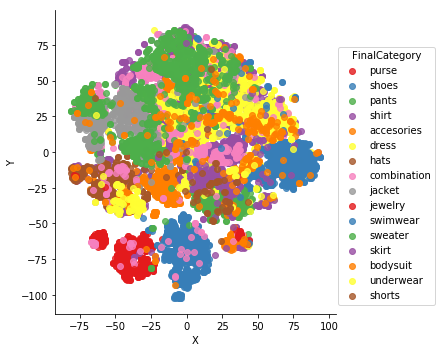

In [54]:
import seaborn as sns
sns.lmplot(data = DF5,x='X', y='Y', hue='FinalCategory',  palette="Set1",fit_reg=False)
plt.show()

We could improve on it by training a word embedding algorithm using fashion-related texts where the item's definition can be inferred from context.

### Method 2: Using custom word2vec model, trained on the provided data

In [55]:
from gensim.models import Word2Vec
documents = DF5['Tokenized'].dropna().tolist()

model = gensim.models.Word2Vec(
        documents,
        size=100,
        window=10,
        min_count=1,
        workers=2)

In [56]:
model.train(documents, total_examples=len(documents), epochs=5000)

(274717008, 502605000)

Testing similarity of words:

In [57]:
model.wv.most_similar('coat')

[('jacket', 0.6200275421142578),
 ('cardigan', 0.5975002646446228),
 ('sweater', 0.5088441371917725),
 ('blazer', 0.4758133888244629),
 ('sweatshirt', 0.47576528787612915),
 ('hoodie', 0.4635555148124695),
 ('t-shirt', 0.44968128204345703),
 ('blouse', 0.3642207384109497),
 ('knitwear', 0.3501884937286377),
 ('shirt', 0.34829726815223694)]

In [58]:
model.wv.most_similar('blouse')

[('t-shirt', 0.7295939922332764),
 ('dress', 0.6755239367485046),
 ('knitwear', 0.5905109643936157),
 ('romper', 0.5810409784317017),
 ('cardigan', 0.5467664003372192),
 ('sweater', 0.5117546916007996),
 ('jumpsuit', 0.45997488498687744),
 ('cover-up', 0.4008714556694031),
 ('blazer', 0.3992779850959778),
 ('sweatshirt', 0.3954651653766632)]

In [59]:
model.wv.most_similar('socks')

[('visor', 0.38218796253204346),
 ('pantyhose', 0.380696564912796),
 ('stockings', 0.3746483325958252),
 ('suspenders', 0.33905208110809326),
 ('beret', 0.3373880684375763),
 ('modish', 0.33448174595832825),
 ('bib', 0.33337971568107605),
 ('resistant', 0.3204270303249359),
 ('carving', 0.3156660199165344),
 ('military', 0.31339889764785767)]

In [60]:
model.wv.most_similar('bodysuit')

[('crop', 0.3640347421169281),
 ('knitwear', 0.3530680537223816),
 ('sweater', 0.34355926513671875),
 ('swimming', 0.33194515109062195),
 ('blazers', 0.3281713128089905),
 ('jumpsuit', 0.32644522190093994),
 ('cover-up', 0.3204983174800873),
 ('top+solid', 0.32001447677612305),
 ('candigan', 0.30388444662094116),
 ('open', 0.3002428114414215)]

In [61]:
model.wv.most_similar('trendy')

[('fashionable', 0.8750389814376831),
 ('casual', 0.8451974391937256),
 ('stylish', 0.8291158080101013),
 ('chic', 0.7981435060501099),
 ('sweet', 0.769105851650238),
 ('sexy', 0.7669385075569153),
 ('elegant', 0.7352933287620544),
 ('simple', 0.7204828262329102),
 ('fashion', 0.7018173933029175),
 ('vintage', 0.6909223794937134)]

Now that the model is built, we can create vectors from the filtered tokens and repeat the process:

/home/ilan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


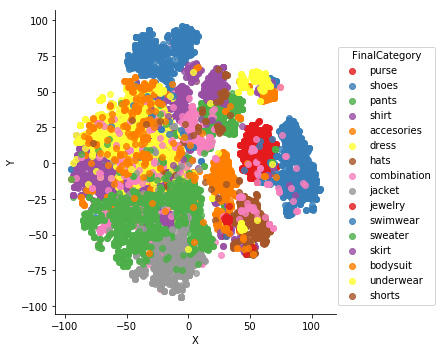

In [62]:
DF4['Vector2'] = DF4['FilteredTokens'].apply(lambda row: calcMeanVec(row))
DFdrop2 = DF4[pd.notnull(DF4['Vector2'])]
numRows = DFdrop2.shape[0]

X = np.zeros((numRows,DFdrop2['Vector2'].iloc[0].shape[0]))
for i in range(0,numRows):
    X[i,:] = DFdrop2['Vector2'].iloc[i]
    
tsne2 = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne2 = tsne2.fit_transform(X)

tsneDF2 = pd.DataFrame(data=X_tsne2,columns=['X','Y'],index=DFdrop2.index)
#tsneDF.head()

DF6 = pd.concat([DFdrop2,tsneDF2],axis=1).drop(['Vector2'],axis=1)

DF6.to_csv('TSNEDataFrame2.csv')

sns.lmplot(data = DF6,x='X', y='Y', hue='FinalCategory',  palette="Set1",fit_reg=False)
plt.show()

We can clearly see clusters corresponding to the categories.